In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

import torchvision
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
from torchinfo import summary
from collections import OrderedDict
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 16

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:03<00:00, 46726089.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


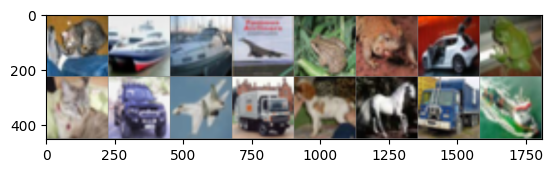

Ground Truth: cat ship ship airplane frog frog automobile frog cat automobile airplane truck dog horse truck ship


In [4]:
# Show some example images from the CIFAR-10 dataset
classes = train_dataset.classes

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images
images, labels = next(iter(test_loader))

# Show the images and their labels
imshow(torchvision.utils.make_grid(images))
print('Ground Truth:', ' '.join(classes[labels[j]] for j in range(16)))


In [5]:
# class ConvBnAct(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, conv_kwargs={}, Bn=nn.BatchNorm2d, actvtion=nn.SiLU(),
#                 ):
#         super(ConvBnAct, self).__init__()

#         self.Conv_BN_Act = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, bias=False, kernel_size=kernel_size,**conv_kwargs),
#             Bn(out_channels),
#             nn.SiLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.Conv_BN_Act(x)


# class ResBlock(nn.Module):
#     def __init__(self, block, shortcutblock=None):
#         super(ResBlock, self).__init__()
#         self.block = block
#         self.shortcut = shortcutblock

#     def forward(self, x):
#         xres = x
#         x = self.block(x)
#         if x.shape == xres.shape:
#             x = x + xres
#         else:
#             assert isinstance(self.shortcut, nn.Module), 'shortcutblock must be a conv layer to match the shape of residuals and outputs'
#             x = self.shortcut(xres) + x
#         return x



# class MyModel(nn.Module):
#     def __init__(self, num_classes ,dropout = 0.1):
#         super(MyModel, self).__init__()

#         self.conv_1 =  nn.Sequential(
#          ConvBnAct(in_channels=3, out_channels=64, kernel_size=7,conv_kwargs= {"stride":1, "padding":3} ),
#          nn.MaxPool2d(kernel_size=3, stride=2, padding= 1)
#         )
#         #-----
#         conv_2_1    =  nn.Sequential(
#                         ConvBnAct(in_channels=64, out_channels=64, kernel_size=3, conv_kwargs= {"stride":2, "padding":1}),
#                         ConvBnAct(in_channels=64, out_channels=64, kernel_size=3, conv_kwargs= {"stride":1, "padding":1})
#                     )
#         conv_2_2    =  nn.Sequential(
#                         ConvBnAct(in_channels=64, out_channels=64, kernel_size=3, conv_kwargs= {"stride":1, "padding":1}),
#                         ConvBnAct(in_channels=64, out_channels=64, kernel_size=3, conv_kwargs= {"stride":1, "padding":1})
#                     )
#         self.conv_2 =  nn.Sequential(
#                         ResBlock(conv_2_1 ,self.shortcut_downsample(64,64) ) ,
#                         ResBlock(conv_2_2 ) ,
#                     )
#         #-----
#         conv_3_1    =  nn.Sequential(
#                         ConvBnAct(in_channels=64, out_channels=128, kernel_size=3, conv_kwargs= {"stride":2, "padding":1}),
#                         ConvBnAct(in_channels=128, out_channels=128, kernel_size=3, conv_kwargs= {"stride":1, "padding":1})
#                     )
#         conv_3_2    =  nn.Sequential(
#                         ConvBnAct(in_channels=128, out_channels=128, kernel_size=3, conv_kwargs= {"stride":1, "padding":1}),
#                         ConvBnAct(in_channels=128, out_channels=128, kernel_size=3, conv_kwargs= {"stride":1, "padding":1})
#                     )
#         self.conv_3 =  nn.Sequential(
#                         ResBlock(conv_3_1 ,self.shortcut_downsample(64,128) ) ,
#                         ResBlock(conv_3_2 )
#                     )
#         #-----
#         conv_4_1    =  nn.Sequential(
#                         ConvBnAct(in_channels=128, out_channels=256, kernel_size=3, conv_kwargs= {"stride":2, "padding":1}),
#                         ConvBnAct(in_channels=256, out_channels=256, kernel_size=3, conv_kwargs= {"stride":1, "padding":1})
#                     )
#         conv_4_2    =  nn.Sequential(
#                         ConvBnAct(in_channels=256, out_channels=256, kernel_size=3, conv_kwargs= {"stride":1, "padding":1}),
#                         ConvBnAct(in_channels=256, out_channels=256, kernel_size=3, conv_kwargs= {"stride":1, "padding":1})
#                     )
#         self.conv_4 =  nn.Sequential(
#                         ResBlock(conv_4_1 ,self.shortcut_downsample(128,256) ) ,
#                         ResBlock(conv_4_2 )
#                     )
#         #-----
#         conv_5_1    =  nn.Sequential(
#                         ConvBnAct(in_channels=256, out_channels=512, kernel_size=3, conv_kwargs= {"stride":2, "padding":1}),
#                         ConvBnAct(in_channels=512, out_channels=512, kernel_size=3, conv_kwargs= {"stride":1, "padding":1})
#                     )
#         conv_5_2    =  nn.Sequential(
#                         ConvBnAct(in_channels=512, out_channels=512, kernel_size=3, conv_kwargs= {"stride":1, "padding":1}),
#                         ConvBnAct(in_channels=512, out_channels=512, kernel_size=3, conv_kwargs= {"stride":1, "padding":1})
#                     )
#         self.conv_5 =  nn.Sequential(
#                         ResBlock(conv_5_1 ,self.shortcut_downsample(256,512) ) ,
#                         ResBlock(conv_5_2 )
#                     )
#         #-----
#         self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc       = nn.Sequential(  nn.Flatten(1),
#                             nn.Dropout(dropout),
#                             nn.Linear(512, num_classes)
#                             )

#     def shortcut_downsample(self, in_channels, out_channels):
#         short_block = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(out_channels)
#          )
#         return short_block

#     def forward(self, x):

#         #x = self.backbone(x)
#         x =self.conv_1(x)
#         x =self.conv_2(x)
#         x =self.conv_3(x)
#         x =self.conv_4(x)
#         x =self.conv_5(x)
#         x =self.avg_pool(x)
#         x =self.fc(x)

#         return x

In [6]:
# # Create an instance of the AlexNet model
# model = MyModel(10 , 0).to(device)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [7]:
# input_size = (1,3, 224, 224)
# summary(model, input_size=input_size ,depth = 1 ,row_settings=["var_names"] )

In [8]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.SiLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

class MobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = DepthwiseSeparableConv(3, 32, stride=2)
        self.conv2 = DepthwiseSeparableConv(32, 64, stride=1)
        self.conv3 = DepthwiseSeparableConv(64, 128, stride=2)
        self.conv4 = DepthwiseSeparableConv(128, 128, stride=1)
        self.conv5 = DepthwiseSeparableConv(128, 256, stride=2)
        self.conv6 = DepthwiseSeparableConv(256, 256, stride=1)
        self.conv7 = DepthwiseSeparableConv(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Create an instance of the MobileNet model
model = MobileNet(num_classes=10).to(device)

In [9]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

input_size = (1, 3, 224, 224)
summary(model, input_size=input_size, depth=1, row_settings=["var_names"])

Layer (type (var_name))                  Output Shape              Param #
MobileNet (MobileNet)                    [1, 10]                   --
├─DepthwiseSeparableConv (conv1)         [1, 32, 112, 112]         187
├─DepthwiseSeparableConv (conv2)         [1, 64, 112, 112]         2,464
├─DepthwiseSeparableConv (conv3)         [1, 128, 56, 56]          9,024
├─DepthwiseSeparableConv (conv4)         [1, 128, 56, 56]          17,792
├─DepthwiseSeparableConv (conv5)         [1, 256, 28, 28]          34,432
├─DepthwiseSeparableConv (conv6)         [1, 256, 28, 28]          68,352
├─DepthwiseSeparableConv (conv7)         [1, 512, 14, 14]          134,400
├─AdaptiveAvgPool2d (avgpool)            [1, 512, 1, 1]            --
├─Linear (fc)                            [1, 10]                   5,130
Total params: 271,781
Trainable params: 271,781
Non-trainable params: 0
Total mult-adds (M): 219.26
Input size (MB): 0.60
Forward/backward pass size (MB): 51.28
Params size (MB): 1.09
Estimated Tota

Epoch 1/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 1/16 - Train Loss: 1.7356 - Train Accuracy: 35.79% - Test Loss: 1.4811 - Test Accuracy: 46.13%


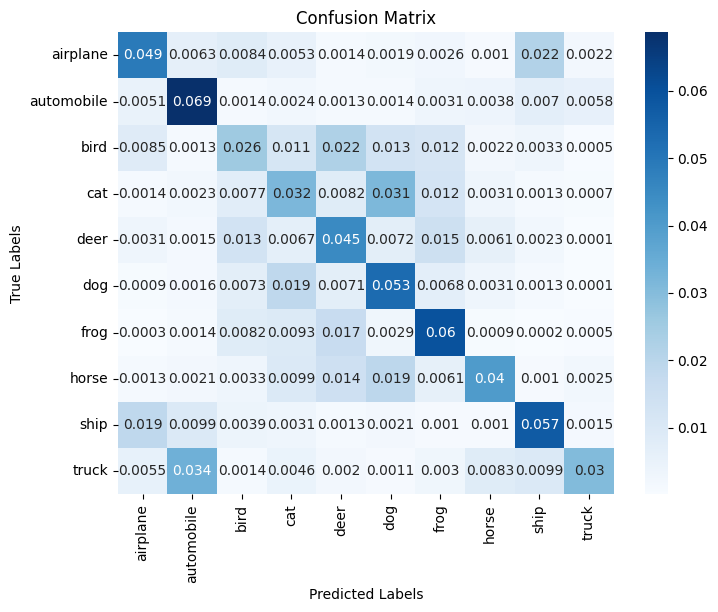

Epoch 2/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 2/16 - Train Loss: 1.4256 - Train Accuracy: 48.60% - Test Loss: 1.2723 - Test Accuracy: 53.90%


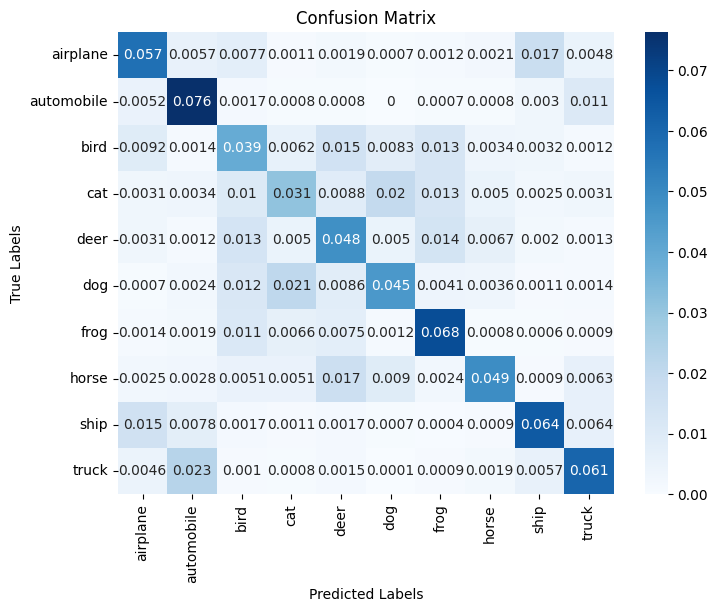

Epoch 3/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 3/16 - Train Loss: 1.2751 - Train Accuracy: 54.58% - Test Loss: 1.1981 - Test Accuracy: 57.78%


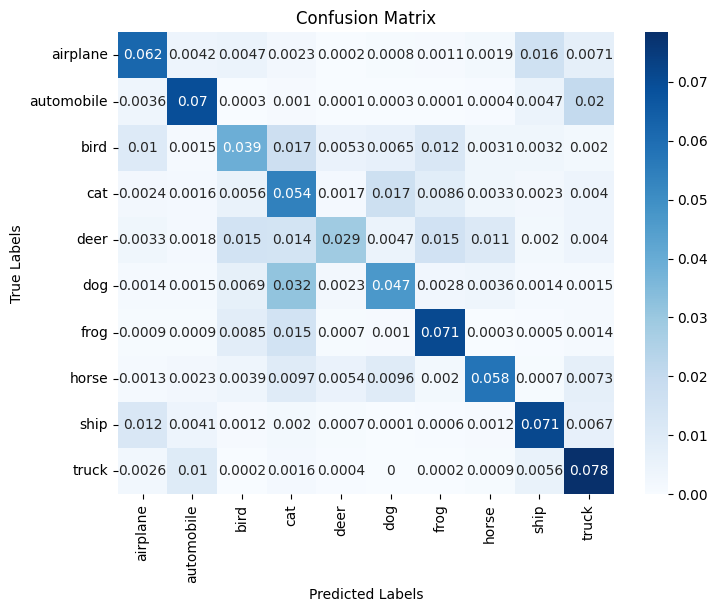

Epoch 4/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 4/16 - Train Loss: 1.1719 - Train Accuracy: 58.46% - Test Loss: 1.0765 - Test Accuracy: 61.87%


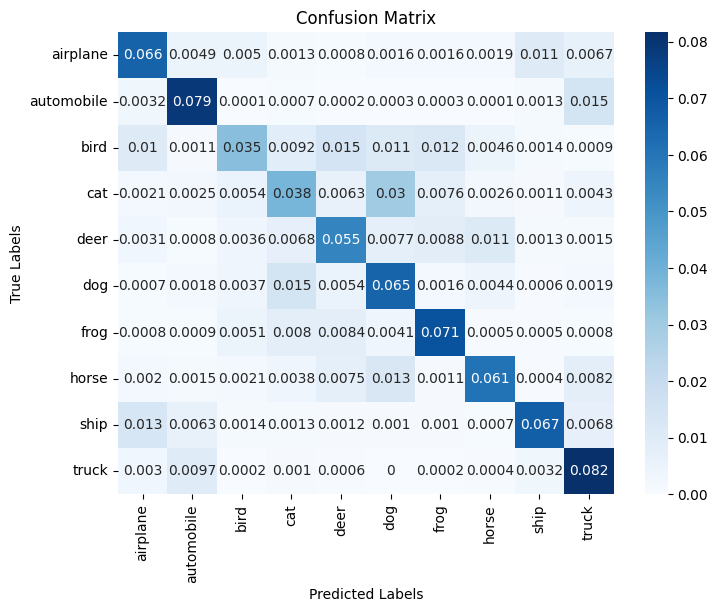

Epoch 5/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 5/16 - Train Loss: 1.0876 - Train Accuracy: 61.78% - Test Loss: 1.0000 - Test Accuracy: 64.93%


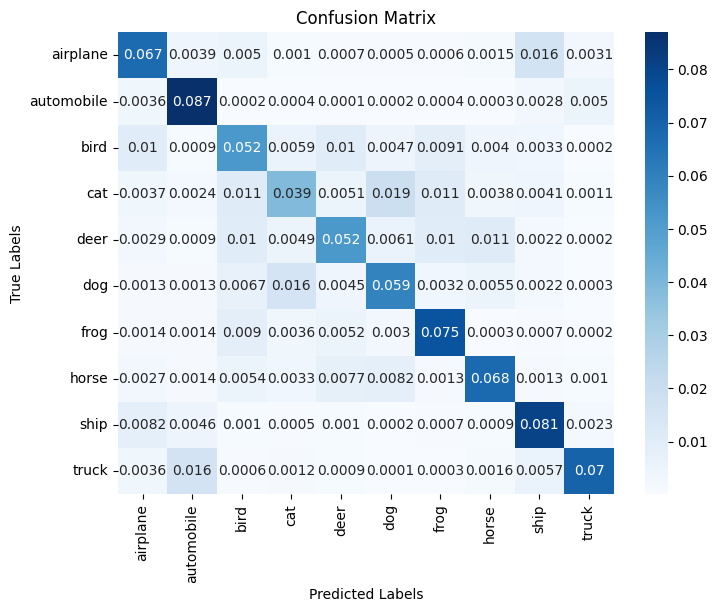

Epoch 6/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 6/16 - Train Loss: 1.0301 - Train Accuracy: 63.79% - Test Loss: 1.0079 - Test Accuracy: 64.94%


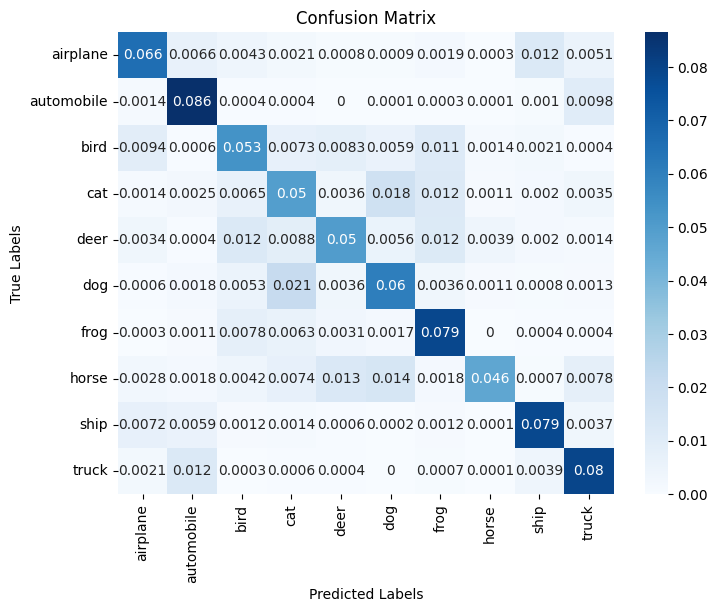

Epoch 7/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 7/16 - Train Loss: 0.9696 - Train Accuracy: 66.17% - Test Loss: 0.9385 - Test Accuracy: 66.99%


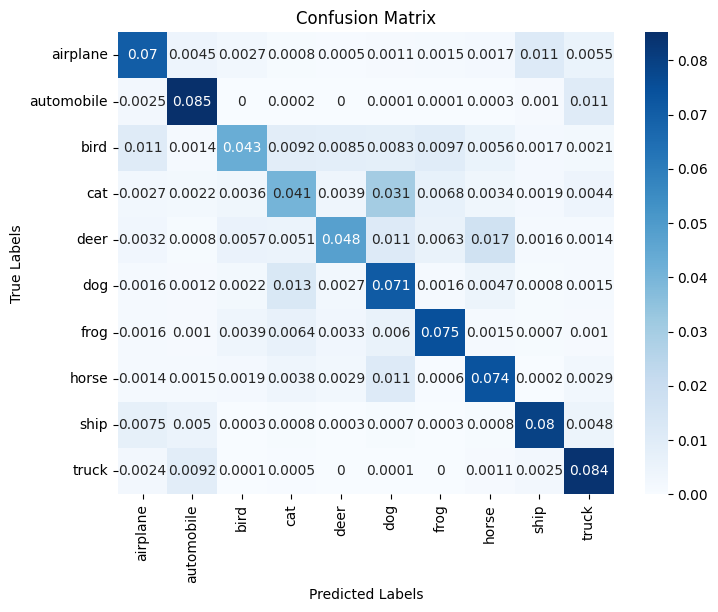

Epoch 8/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 8/16 - Train Loss: 0.9247 - Train Accuracy: 67.83% - Test Loss: 0.9214 - Test Accuracy: 68.11%


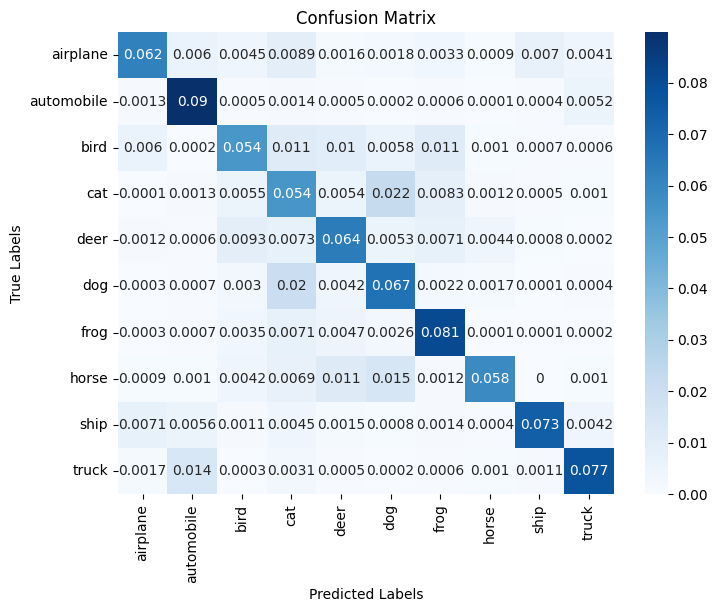

Epoch 9/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 9/16 - Train Loss: 0.8813 - Train Accuracy: 69.39% - Test Loss: 0.8679 - Test Accuracy: 69.73%


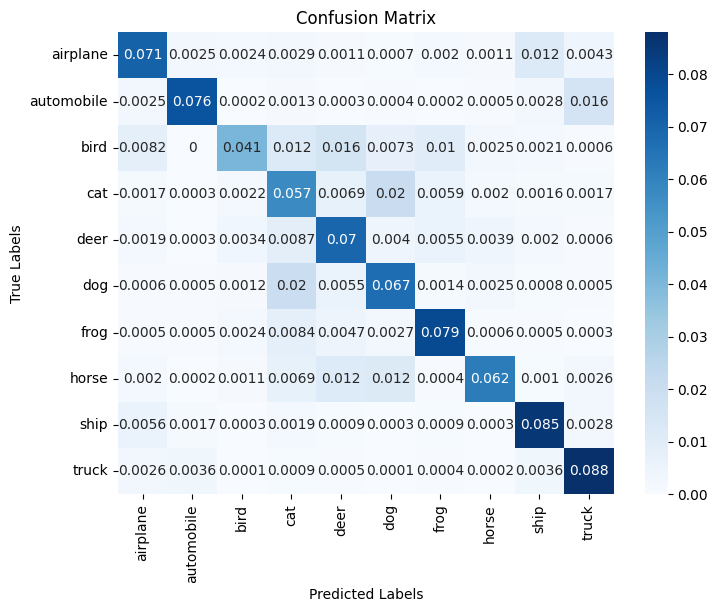

Epoch 10/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 10/16 - Train Loss: 0.8432 - Train Accuracy: 70.63% - Test Loss: 0.8419 - Test Accuracy: 70.28%


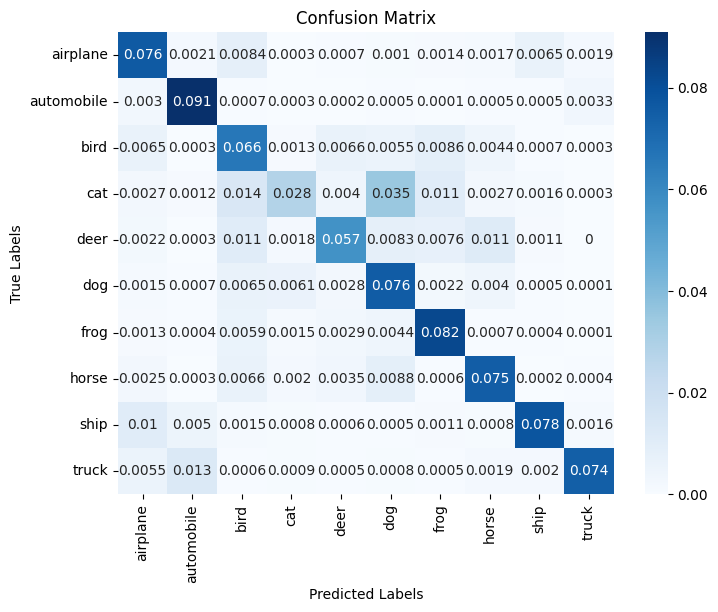

Epoch 11/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 11/16 - Train Loss: 0.8068 - Train Accuracy: 72.10% - Test Loss: 0.8861 - Test Accuracy: 68.87%


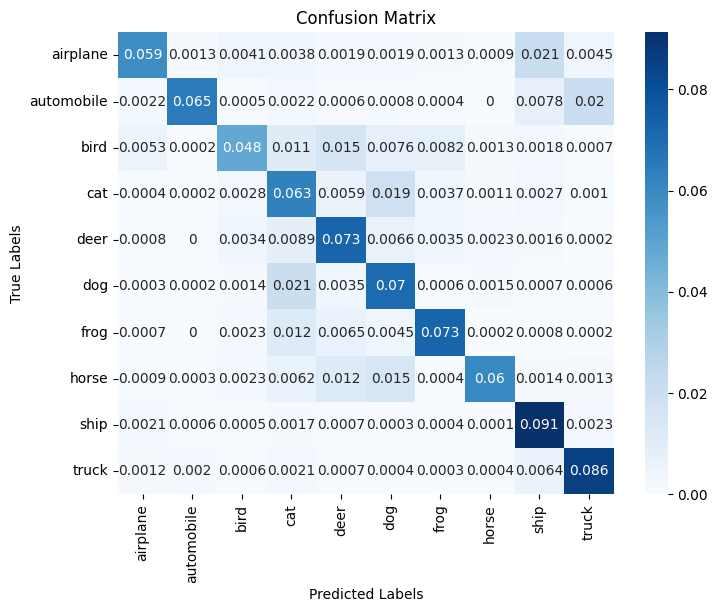

Epoch 12/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 12/16 - Train Loss: 0.7754 - Train Accuracy: 73.28% - Test Loss: 0.7971 - Test Accuracy: 72.13%


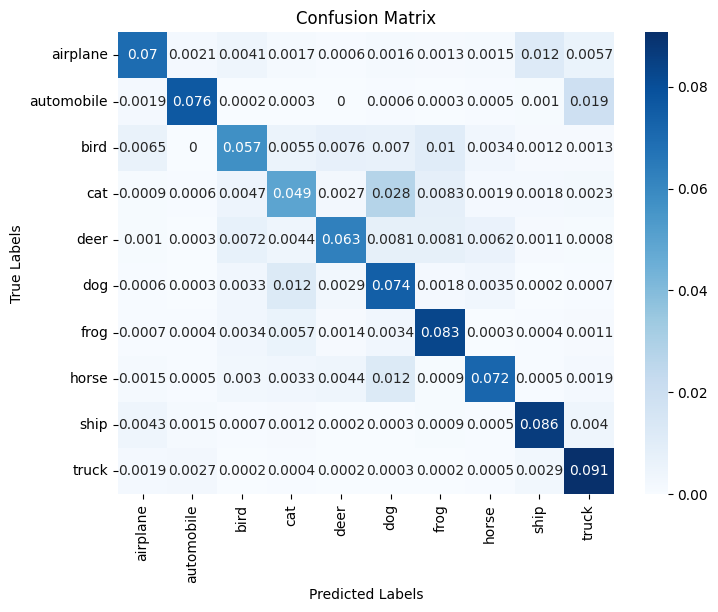

Epoch 13/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 13/16 - Train Loss: 0.7442 - Train Accuracy: 74.26% - Test Loss: 0.7809 - Test Accuracy: 72.88%


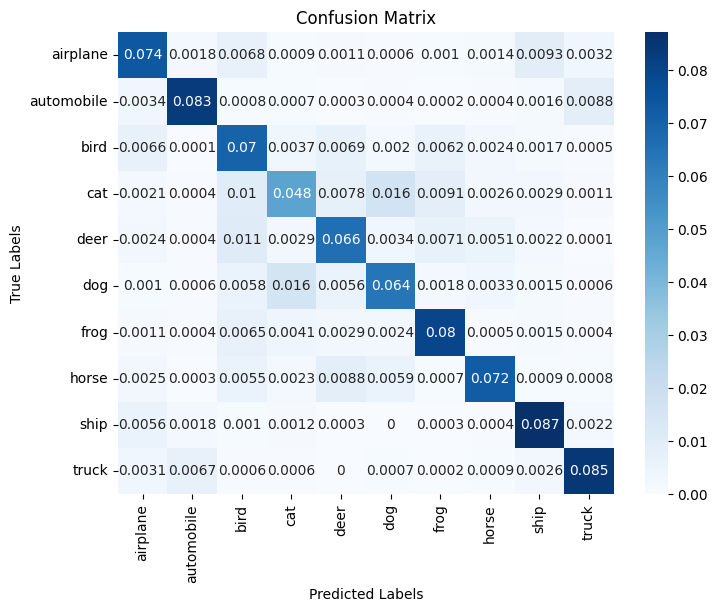

Epoch 14/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 14/16 - Train Loss: 0.7115 - Train Accuracy: 75.54% - Test Loss: 0.7650 - Test Accuracy: 73.39%


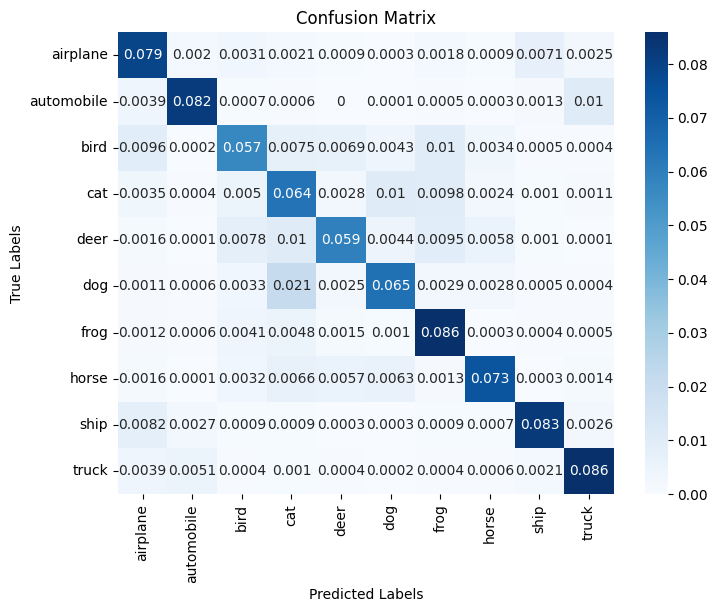

Epoch 15/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 15/16 - Train Loss: 0.6902 - Train Accuracy: 76.40% - Test Loss: 0.7559 - Test Accuracy: 74.06%


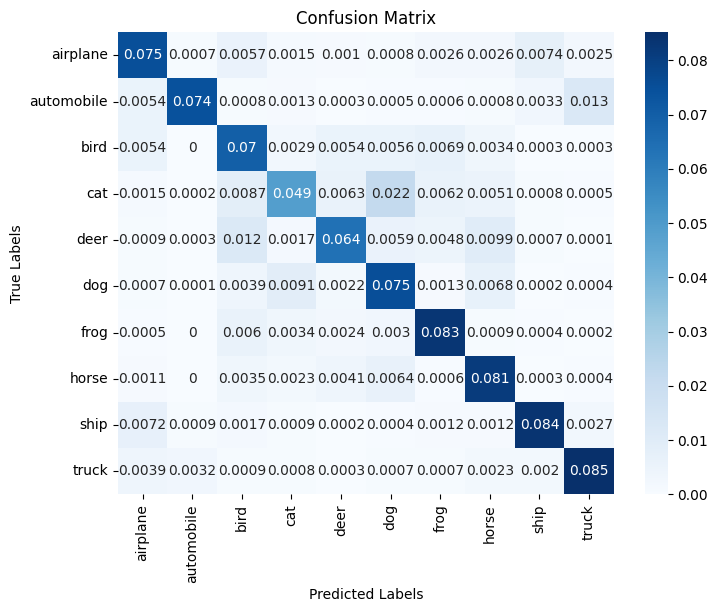

Epoch 16/16:   0%|          | 0/3125 [00:00<?, ?batch/s]

Epoch 16/16 - Train Loss: 0.6640 - Train Accuracy: 77.14% - Test Loss: 0.7538 - Test Accuracy: 73.68%


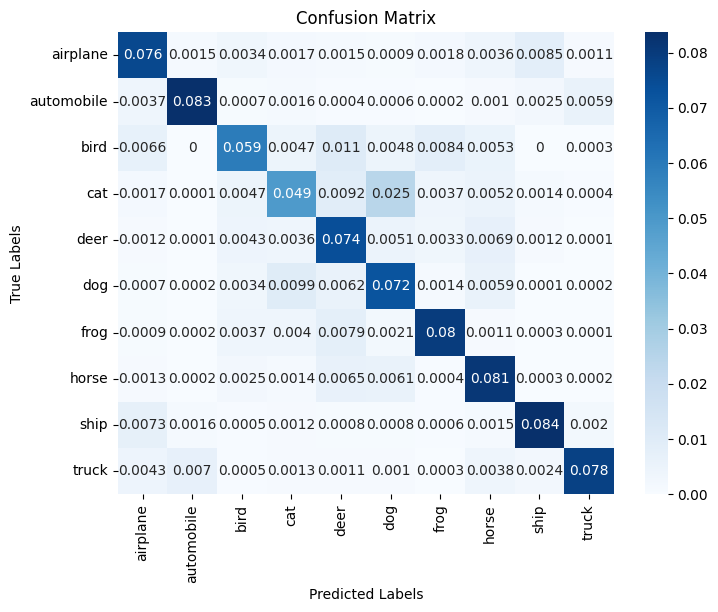

In [10]:
# Training loop
num_epochs = 16
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # Update the progress bar
        pbar.update(1)
        pbar.set_postfix({'Loss': loss.item()})

    # Close the progress bar
    pbar.close()

    train_loss /= len(train_loader)
    train_accuracy = 100.0 * correct / total
#------------------------------------------------------------------------------
    # Validation loop
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_predicted = []

    all_labels = []


    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_predicted.append(predicted)
            all_labels.append(labels)



    # Convert the lists to tensors
    all_predicted = torch.cat(all_predicted).tolist()
    all_labels = torch.cat(all_labels).tolist()

    test_loss /= len(test_loader)
    test_accuracy = 100.0 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predicted ,normalize= 'all')

    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}% - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes )
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

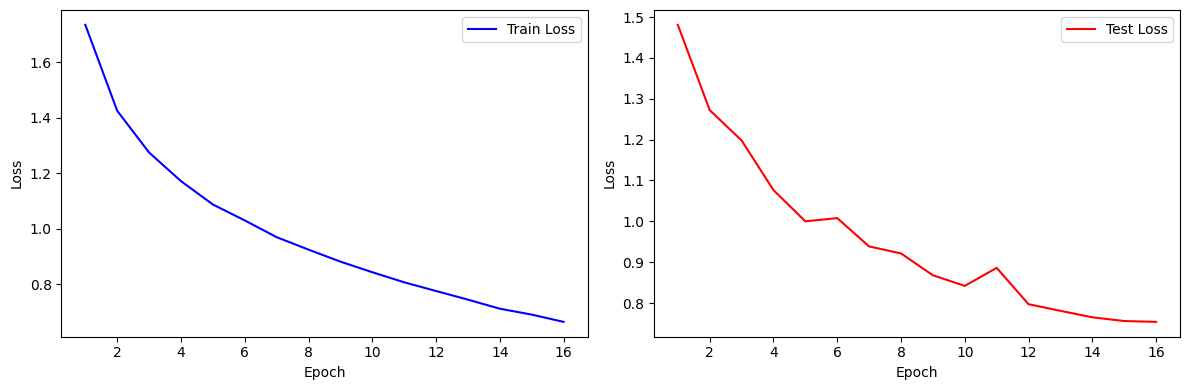

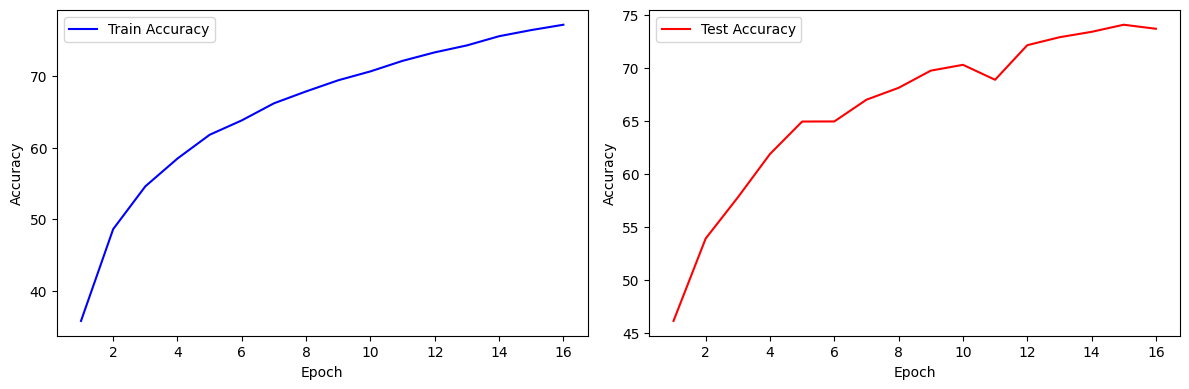

In [11]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot test loss
plt.subplot(1, 2, 2)
plt.plot(epochs, test_losses, 'r-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))

# Plot train accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()